In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c924bf5ba510f53df98c11459dc9e12f546c5b86f86d4fbfb853775aa92285f2
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

In [3]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [4]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Random Forest Model


Random Forest Evaluation
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1 Score: 0.94
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.93      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



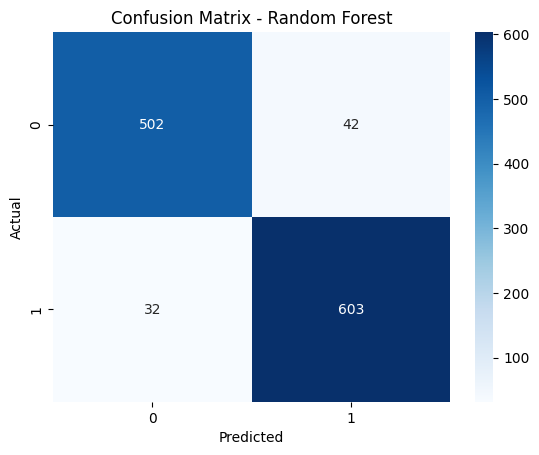

In [5]:
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_train_final, y_train)
evaluate_model("Random Forest", rf_final, X_test_final, y_test)

### PFI for Random Forest

Permutation Feature Importance - Random Forest


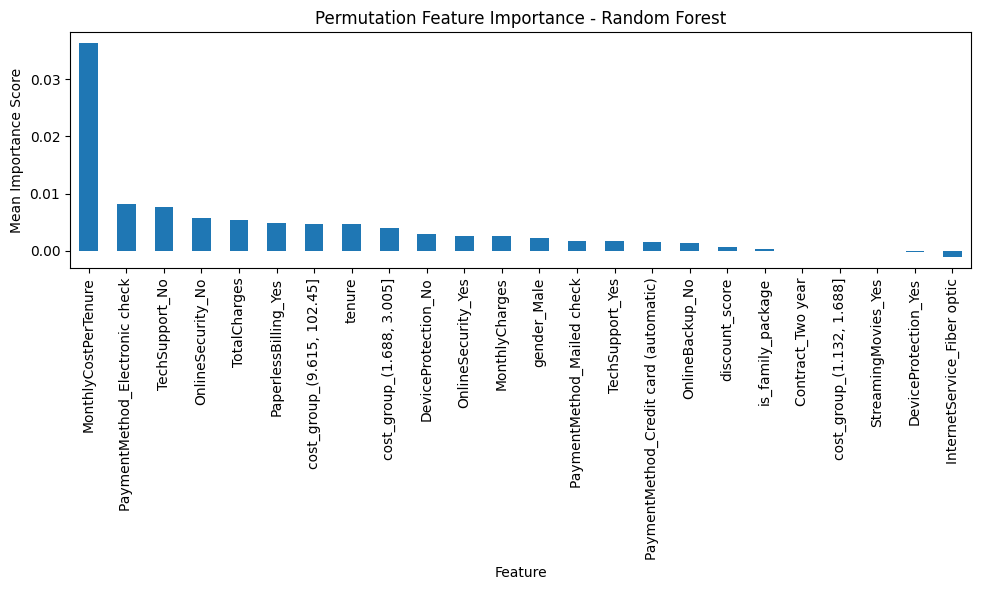

In [10]:
print("Permutation Feature Importance - Random Forest")
result = permutation_importance(
    rf_final, X_test_final, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance_scores = pd.Series(result.importances_mean, index=X_test_final.columns)
importance_scores = importance_scores.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importance_scores.plot(kind='bar')
plt.title("Permutation Feature Importance - Random Forest")
plt.ylabel("Mean Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

The bar plot illustrates the global importance of features used by the Random Forest classifier, computed using permutation importance. This method measures how much each feature contributes to the model’s predictive performance by evaluating the decrease in accuracy when its values are randomly shuffled.

Key Interpretations:

* Top Feature – MonthlyCostPerTenure:

    This feature has the highest mean importance score, indicating that it plays a critical role in predicting customer churn.

    Randomizing this feature's values causes the most significant drop in model performance.

* Important Categorical Features:

    Features like PaymentMethod_Electronic check, TechSupport_No, and OnlineSecurity_No are also important.

    These reflect service preferences and lack of security/support, which may correlate with higher churn rates.

* Moderately Important Features:

    TotalCharges, PaperlessBilling_Yes, and certain cost_group bins show moderate influence.

    These likely reflect customer billing behavior and subscription duration.

* Low-Importance Features:

    Features like DeviceProtection_Yes, StreamingMovies_Yes, and some PaymentMethod categories have near-zero or even slightly negative importance.

    Their shuffling does not impact model accuracy significantly, suggesting they are not informative or are redundant in the presence of more relevant features.



### LIME for Random Forest

In [6]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [ ]:
print("LIME Explanation for Random Forest")
exp = explainer.explain_instance(sample_instance.values, rf_final.predict_proba)
exp.show_in_notebook()

LIME Explanation for Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


This LIME explanation shows that the Random Forest model predicts a 59% chance of churn for the selected customer. The prediction is mainly driven by:

* High MonthlyCostPerTenure

* Very short tenure (≤ 4 months)

* No Tech Support, Online Security, or Device Protection

### PDP for Random Forest

In [ ]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)

PDP - Random Forest


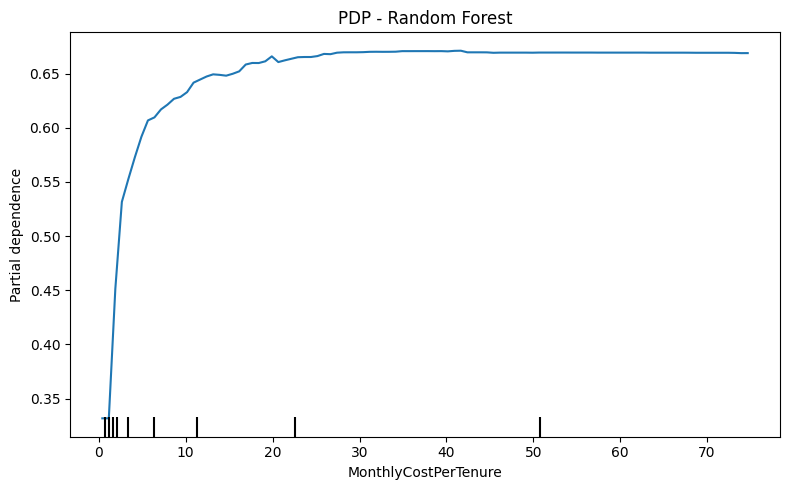

In [ ]:
print("PDP - Random Forest")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(rf_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Random Forest")
plt.tight_layout()
plt.show()

This PDP shows that as MonthlyCostPerTenure increases, the likelihood of churn also increases—especially sharply at low values.

The curve levels off after around 20, indicating that beyond this point, higher costs don’t significantly raise the churn risk further.

### ICE for Random Forest

ICE - Random Forest


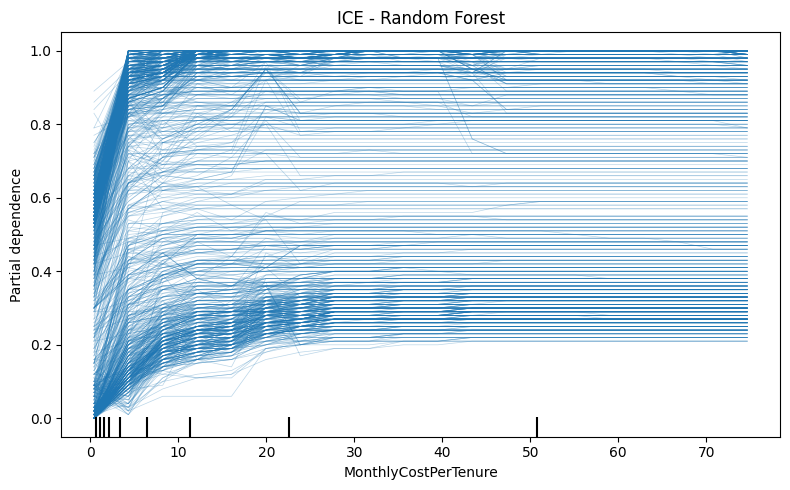

In [ ]:
print("ICE - Random Forest")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(rf_final, X_test_final, features=[feature_index], kind="individual", grid_resolution=20, ax=ax)
ax.set_title("ICE - Random Forest")
plt.tight_layout()
plt.show()

This ICE plot illustrates how the MonthlyCostPerTenure feature affects the churn prediction for individual customers.

Most lines trend upward, especially at low values, meaning as MonthlyCostPerTenure increases, predicted churn probability rises for many customers. The variation among lines shows individual sensitivity—some customers are more affected than others. This supports the PDP trend while revealing heterogeneity in individual responses.